### 作業目的: 實作word2vec Skip-gram模型
在課程中了解如何搭建CBOW模型，這次的作業目的在於透過搭建Skip-gram模型來了解另外一種word2vec的架構。

Hint_1: 學員可以善用課程中以搭建好的function模組
Hint_2: Skip_gram所需的輸入資料與目標跟CBOW有些許不同，Skip_gram是由中間字詞預測上下文

In [1]:
# import modules
import numpy as np
from typing import List
from utils.utility import clip_grads, convert_one_hot, preprocess, Trainer
from utils.layers import Dense, SoftmaxWithCrossEntropy
from utils.optimizer import SGD

In [20]:
# use the same corpus as in the lecture
text = "I am studying Natural Language Processing now. It is not my fault to be honest and this is the root cause of being chill."

# define create_contexts_target function
def create_contexts_target(corpus: List, window_size: int=1):

    contexts = corpus[window_size:-window_size]
    targets = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                # skip target word itself
                continue
            cs.append(corpus[idx + t])
        targets.append(cs)

    return np.array(contexts), np.array(targets)

# transform corpus to contexts and targets pair
corpus, word2idx, idx2word = preprocess([text])
contexts, targets= create_contexts_target(corpus[0], window_size=1)
contexts, targets

(array([ 4,  8,  7, 23, 18, 13, 22, 20,  2, 10,  3, 17,  5, 19, 14,  1,  9,
         2,  0, 15, 21,  6, 11, 16]),
 array([[12,  8],
        [ 4,  7],
        [ 8, 23],
        [ 7, 18],
        [23, 13],
        [18, 22],
        [13, 20],
        [22,  2],
        [20, 10],
        [ 2,  3],
        [10, 17],
        [ 3,  5],
        [17, 19],
        [ 5, 14],
        [19,  1],
        [14,  9],
        [ 1,  2],
        [ 9,  0],
        [ 2, 15],
        [ 0, 21],
        [15,  6],
        [21, 11],
        [ 6, 16],
        [11, 22]]))

In [21]:
# transform contexts and targets to one-hot encoding
def convert_one_hot(corpus, vocab_size):
    N = corpus.shape[0]
    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1
    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1
    return one_hot
contexts = convert_one_hot(contexts, len(word2idx))
targets = convert_one_hot(targets, len(word2idx))
contexts, targets

(array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],

In [22]:
# define Skip-gram model
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size):
        V, H = vocab_size, hidden_size
        self.window_size = window_size

        # initialize weights
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # create layers
        self.in_layer = Dense(W_in)
        self.out_layer = Dense(W_out)
        self.loss_layers = [SoftmaxWithCrossEntropy() for i in range(window_size*2)]
        

        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # word vector matrix
        self.word_vecs = W_in

    def forward(self, contexts, targets):
        h = self.in_layer.forward(contexts)
        s = self.out_layer.forward(h)
        
        loss = sum([self.loss_layers[i].forward(s, targets[:, i]) for i in range(self.window_size*2)])
        return loss

    def backward(self, dout=1):
        
        ds = sum([self.loss_layers[i].backward(dout) for i in range(self.window_size*2)])
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        
        return None

In [23]:
# start training

# configurations
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

# define model
skip_gram = SkipGram(vocab_size=len(word2idx), hidden_size=hidden_size, window_size=window_size)
sgd_optimizer = SGD()
trainer = Trainer(skip_gram, sgd_optimizer)

# start training
trainer.fit(contexts, targets, max_epoch, batch_size)

24, Iteration: 1/8, Loss: 1.527251082892268
Epoch: 625, Iteration: 1/8, Loss: 1.5821503197125366
Epoch: 626, Iteration: 1/8, Loss: 1.530756260582653
Epoch: 627, Iteration: 1/8, Loss: 1.46876750670833
Epoch: 628, Iteration: 1/8, Loss: 1.5267618585563982
Epoch: 629, Iteration: 1/8, Loss: 1.5269538121763282
Epoch: 630, Iteration: 1/8, Loss: 1.585581555955315
Epoch: 631, Iteration: 1/8, Loss: 1.4683958995995183
Epoch: 632, Iteration: 1/8, Loss: 1.5268694339285704
Epoch: 633, Iteration: 1/8, Loss: 1.5684651203028661
Epoch: 634, Iteration: 1/8, Loss: 1.4707901591747152
Epoch: 635, Iteration: 1/8, Loss: 1.5866112068611153
Epoch: 636, Iteration: 1/8, Loss: 1.467152878137835
Epoch: 637, Iteration: 1/8, Loss: 1.5267001251277805
Epoch: 638, Iteration: 1/8, Loss: 1.5263050404516942
Epoch: 639, Iteration: 1/8, Loss: 1.5268811532305862
Epoch: 640, Iteration: 1/8, Loss: 1.5265784114086225
Epoch: 641, Iteration: 1/8, Loss: 1.5127199187858442
Epoch: 642, Iteration: 1/8, Loss: 1.5265426155567046
Epoch: 

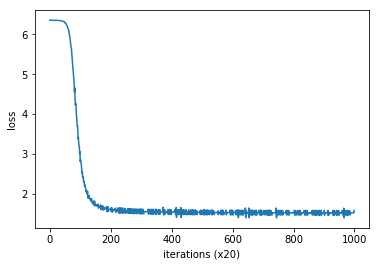

In [24]:
trainer.plot()

In [25]:
# check skip-gram results
word_vecs = skip_gram.word_vecs
for word_id, word in idx2word.items():
    print(word, word_vecs[word_id])

the [-0.29189515  2.8636296  -1.5439332  -0.50900066  0.8405376 ]
and [-0.98317283  0.0947545  -1.5958806   3.4354064  -0.11319128]
is [-0.10533299  0.9361807   0.71556115  1.7638004  -1.0425127 ]
my [-1.1936007 -0.933899   1.6702948  1.0054953 -2.6513004]
am [-1.2053695 -2.10108   -2.5103142  0.0327915 -1.638814 ]
to [-1.9408287  -1.1421211   0.82290107 -1.5401528  -2.56847   ]
of [ 1.4968519 -0.661009   1.3765374  1.5282071  2.520302 ]
natural [ 1.2500145 -0.5250734 -2.5531447 -0.6827757 -2.2600992]
studying [ 0.33334532 -2.946019    0.8059005  -1.7342211   0.5303145 ]
this [-0.22673364  1.0113834  -1.0779226  -3.1752658   0.6014257 ]
not [ 0.9026392   0.46290708 -2.2757547  -1.0664304   2.0392432 ]
being [-3.3047724   0.06912048  0.61318594  0.26941773  1.118591  ]
i [ 0.00043514  0.01019572  0.0077376  -0.02229491 -0.00722159]
now [ 0.6956346   1.4018023   2.692242   -1.460849    0.70900035]
honest [-1.4744018   0.04466248 -0.36363456 -2.9936168  -1.0642077 ]
root [-0.12164203  1.5